<a href="https://colab.research.google.com/github/syahdannoor/Disability_4/blob/Syahdan/UsingTFHubSavedModels_Syahdan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Citra BISINDO Image Classifier Using TFHub SavedModels

Membandingkan 4 Metode Lain :
1. MobileNetV3_Large_100
2. InceptionV3
3. ResnetV2_50
4. VGG19
5. EfficientNetB7



## Import

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.python.client import device_lib

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

device_lib.list_local_devices()

TF version: 2.8.2
Hub version: 0.12.0
GPU is available


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3772738531803538077
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14444920832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13196019753471709357
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

## Select the TF2 SavedModel module to use

In [2]:
#@title Select model :

model_name = "mobilenet_v3_large_100_224" # @param ['efficientnet_b7', 'inception_v3', 'resnet_v2_50', 'mobilenet_v3_large_100_224', 'vgg19-block5-conv2-unpooling-encoder']

model_handle_map = {
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "vgg19-block5-conv2-unpooling-encoder":"https://tfhub.dev/emilutz/vgg19-block5-conv2-unpooling-encoder/1",
}

model_image_size_map = {
  "efficientnet_b7": 600,
  "inception_v3": 299,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32#@param {type:"integer"}

Selected model: mobilenet_v3_large_100_224 : https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5
Input size (224, 224)


## Set up dataset

In [3]:
#@title Download Compressed Dataset Github URL format *.tgz
image_url = 'https://media.githubusercontent.com/media/syahdannoor/Disability_4/Syahdan/dataset/Citra%20BISINDO.tgz?token=AE55EQY6EQ7D6IVFIXUDNNTC4AOTQ' #@param {type:"string"}

data_dir = tf.keras.utils.get_file(
    'Citra BISINDO',
    image_url,
    untar=True)

120168448/120159400 [==============================] - 1s 0us/step


In [4]:
#@title Data Augmentation

def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(5))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 312 files belonging to 26 classes.
Using 250 files for training.
Found 312 files belonging to 26 classes.
Using 62 files for validation.


## Defining the model

In [5]:
trainabler = True #@param {type:"boolean"}

In [6]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=trainabler),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          #activation="softmax",
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4226432   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 26)                33306     
                                                                 
Total params: 4,259,738
Trainable params: 4,235,338
Non-trainable params: 24,400
_________________________________________________________________


## Training the model

In [7]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [8]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
epochs=50 #@param {type:"integer"}
hist = model.fit(
    train_ds,
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/50
7/7 [==============================] - 28s 1s/step - loss: 3.6114 - accuracy: 0.0446 - val_loss: 3.9027 - val_accuracy: 0.0000e+00
Epoch 2/50
7/7 [==============================] - 8s 1s/step - loss: 3.4817 - accuracy: 0.0596 - val_loss: 3.8014 - val_accuracy: 0.0625
Epoch 3/50
7/7 [==============================] - 7s 1s/step - loss: 3.2978 - accuracy: 0.1284 - val_loss: 3.7981 - val_accuracy: 0.0938
Epoch 4/50
7/7 [==============================] - 7s 1s/step - loss: 3.0381 - accuracy: 0.2890 - val_loss: 3.6591 - val_accuracy: 0.0938
Epoch 5/50
7/7 [==============================] - 7s 1s/step - loss: 2.9170 - accuracy: 0.3211 - val_loss: 3.5680 - val_accuracy: 0.1250
Epoch 6/50
7/7 [==============================] - 7s 960ms/step - loss: 2.5671 - accuracy: 0.5000 - val_loss: 3.3421 - val_accuracy: 0.1875
Epoch 7/50
7/7 [==============================] - 7s 962ms/step - loss: 2.3226 - accuracy: 0.6468 - val_loss: 3.2011 - val_accuracy: 0.2188
Epoch 8/50
7/7 [==============

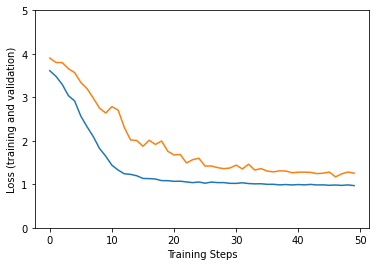

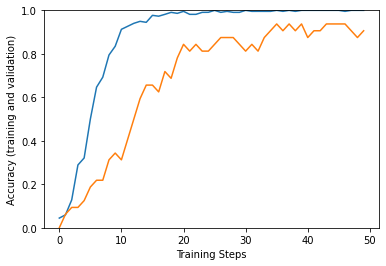

In [9]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,5])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

# Try out the model on an image from the validation data:

Predict validation model with : mobilenet_v3_large_100_224
https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5


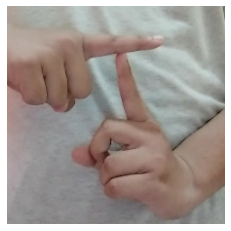

True label: T
Predicted label: T
T With a 93.77 percent confidence.


In [28]:
print("Predict validation model with :", model_name)
print(model_handle)

x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
score = tf.nn.softmax(prediction_scores[0])
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])
print("{} With a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# Optional Save Model

In [32]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

model.save(f"saved_{timestr}_{model_name}.h5")